# 1. Introduction

#### In this notebook, I have tried 2 models. First Model is skip connection neural network using Functional API and then Second Model is a CNN Model. Both of the model achienved approximately same result which is discernible in confusion matrix below after every model. I have used ImageDataGenerator function for Image Augmentation. Scale, Zoom, rotation,shift are some properties that has been changes for image augmentation. Both model performance is also compared at the end of notebook.


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Activation,Lambda,BatchNormalization,Dropout,Flatten,MaxPooling2D,Input,Dense,MaxPool2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy,mse
from tensorflow.keras import backend as K 
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
sample,features = train.shape[0],train.shape[1]
print(f"Train data has {sample} rows and {features} columns")
train.head()

Train data has 42000 rows and 785 columns


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test = pd.read_csv("../input/digit-recognizer/test.csv")
sample,features = test.shape[0],test.shape[1]
print(f"Test data has {sample} rows and {features} columns")
test.head()

Test data has 28000 rows and 784 columns


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


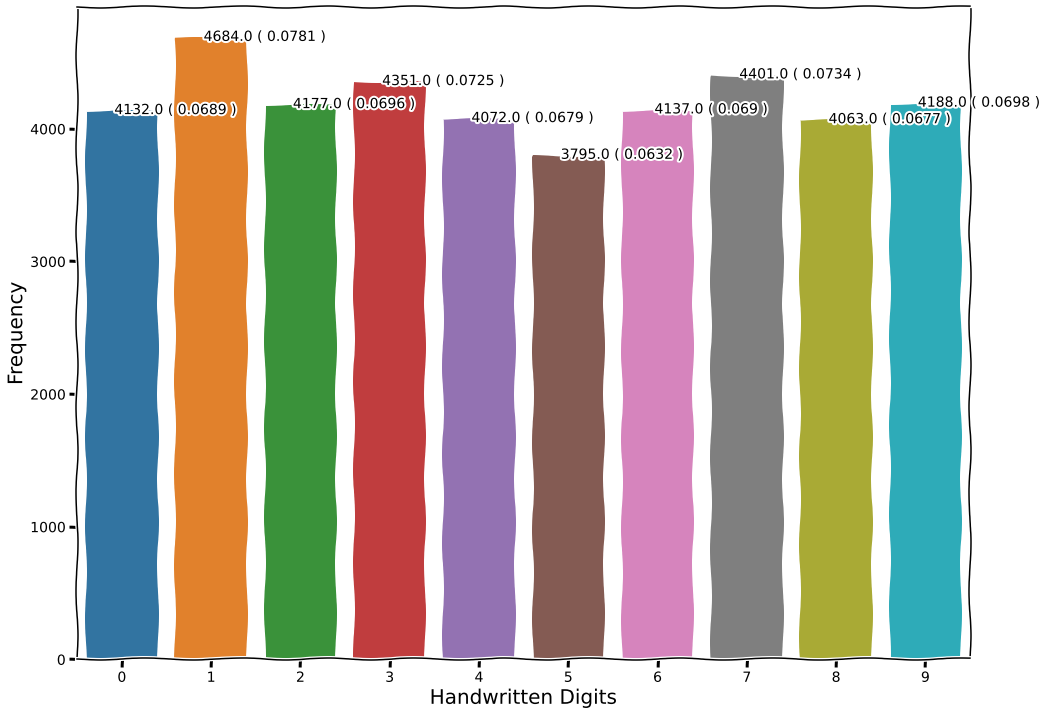

In [5]:
# let's see the distribution of classes
plt.xkcd()
plt.figure(figsize = (16,12))
ax = sns.barplot(x = train['label'].value_counts().index,y = train['label'].value_counts().values)

rects = ax.patches

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + 1,height + 20, str (np.round(height,0)) + " ( " + str (np.round(height/60000,4)) + " )", ha = 'center',va = 'center_baseline')



plt.xlabel("Handwritten Digits",fontsize = 20)
plt.ylabel("Frequency",fontsize = 20)
plt.show()

From above bar plot we can definitely concludes that this is not imbalanced dataset. 

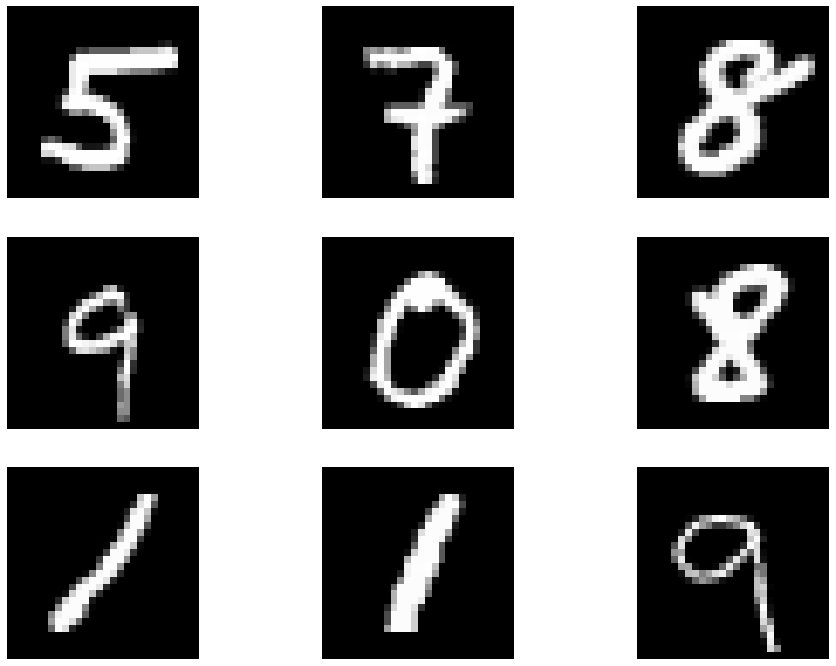

In [6]:
# how our input data looks
from matplotlib import pyplot
plt.figure(figsize = (16,12))
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    r = np.random.choice(10000)
    pyplot.imshow(train.drop(['label'],axis=1).iloc[r].values.reshape(28,28), cmap=pyplot.get_cmap('gray'))
    plt.grid(False)
    plt.axis(False)
plt.show()

In [7]:
def generate_data(df,label = 0):
    X = train[train['label']==label]
    datagen = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,
                                zca_whitening=False,rotation_range = 20,
                                width_shift_range = 0.2,height_shift_range = 0.2,
                                shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True,
                                vertical_flip = True,fill_mode = 'nearest'
                            )
    X = X.drop(['label'],axis=1).values.reshape((X.shape[0], 28, 28, 1))
    datagen.fit(X)
    for x_batch,y_batch in datagen.flow(X,[label]*len(X),batch_size = 9):
        plt.figure(figsize = (16,12))
        for i in range(0,9):
            pyplot.subplot(330 + 1 + i)
            pyplot.imshow(X[i].reshape(28,28), cmap=pyplot.get_cmap('gray'))
        # show the plot
        pyplot.show()
        break

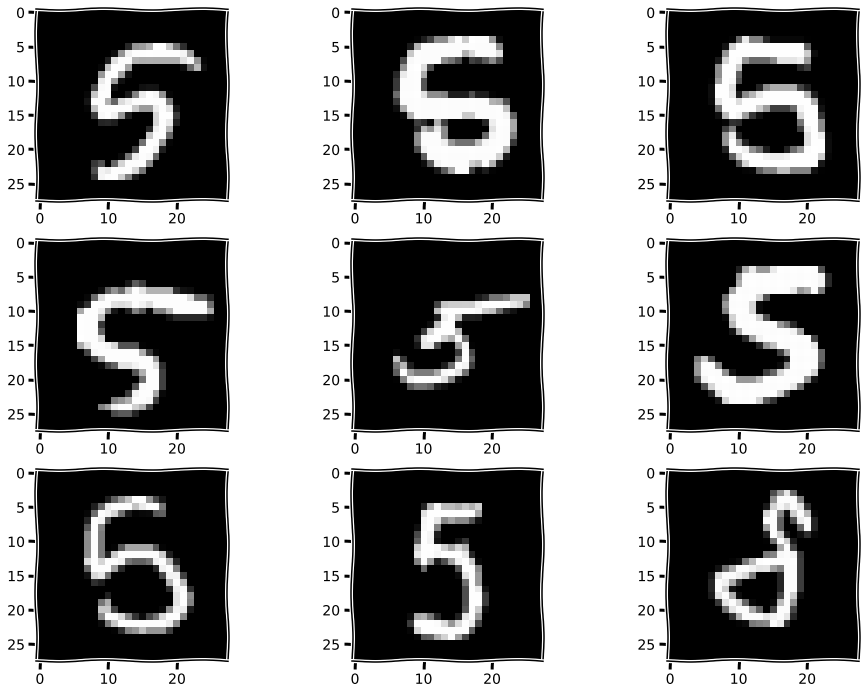

In [8]:
## let's generate augmented image of label 5
generate_data(train,label = 5)
# same can be done using above function for label between 0 to 9


In [12]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

For the data augmentation, i choosed to :

1. Randomly rotate some training images by 10 degrees
2. Randomly Zoom by 10% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height

I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

In [10]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [13]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42,stratify = Y_train)

In [8]:
def ConvNet(x,filters,size,strides=1,batch_norm = True):
    if strides==1:
        padding = 'same'
    else:
        padding = 'valid'
    x = Conv2D(filters = filters,kernel_size = size,strides = strides,padding = padding
              ,use_bias = not batch_norm,kernel_regularizer = tf.keras.regularizers.l2(0.005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    return(x)

def NetResidual(x,filters):
    prev = x
    x = ConvNet(x,filters//2,1)
    x = ConvNet(x,filters,3)
    x = tf.keras.layers.Add()([prev,x])
    return(x)

def NetBlock(x,filters,blocks):
    x = ConvNet(x,filters,3,strides=2)
    for _ in range(blocks):
        x = NetResidual(x,filters)
    return(x)
        
def Network(filters,x_input,name = 'Res_Con'):
    x = inputs = Input(x_input.shape[1:])
    x = ConvNet(x,32,3)
    x = NetBlock(x,64,3)
    x = Flatten()(x)
    x = Dense(256,activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(10,activation = 'softmax')(x)
    return(Model(inputs,x,name = name))

In [14]:
model1 = Network(32,X_train)
model1.summary()

Model: "Res_Con"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
ckpt = ModelCheckpoint('res_model.h5',
                            verbose=1, save_weights_only=True,save_best_only = True)
epochs = 50
batch_size = 86

model1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

In [15]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [16]:
history1 = model1.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 30, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,ckpt])

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 2.4300 - accuracy: 0.6848
Epoch 00001: val_loss improved from inf to 1.99614, saving model to res_model.h5
439/439 [==============================] - 90s 205ms/step - loss: 2.4300 - accuracy: 0.6848 - val_loss: 1.9961 - val_accuracy: 0.8143 - lr: 1.0000e-04
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.6534 - accuracy: 0.8930
Epoch 00002: val_loss improved from 1.99614 to 1.30190, saving model to res_model.h5
439/439 [==============================] - 87s 198ms/step - loss: 1.6534 - accuracy: 0.8930 - val_loss: 1.3019 - val_accuracy: 0.9805 - lr: 1.0000e-04
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 1.3887 - accuracy: 0.9329
Epoch 00003: val_loss improved from 1.30190 to 1.14519, saving model to res_model.h5
439/439 [==============================] - 93s 213ms/step - loss: 1.3887 - accuracy: 0.9329 - val_loss: 1.1452 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 4/

Epoch 26/30
439/439 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.9814
Epoch 00026: val_loss improved from 0.22933 to 0.21978, saving model to res_model.h5
439/439 [==============================] - 88s 201ms/step - loss: 0.2454 - accuracy: 0.9814 - val_loss: 0.2198 - val_accuracy: 0.9914 - lr: 1.0000e-04
Epoch 27/30
439/439 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9827
Epoch 00027: val_loss improved from 0.21978 to 0.20700, saving model to res_model.h5
439/439 [==============================] - 88s 202ms/step - loss: 0.2356 - accuracy: 0.9827 - val_loss: 0.2070 - val_accuracy: 0.9919 - lr: 1.0000e-04
Epoch 28/30
439/439 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.9834
Epoch 00028: val_loss improved from 0.20700 to 0.20365, saving model to res_model.h5
439/439 [==============================] - 87s 198ms/step - loss: 0.2243 - accuracy: 0.9834 - val_loss: 0.2037 - val_accuracy: 0.9905 - lr: 1.0000e-04
E

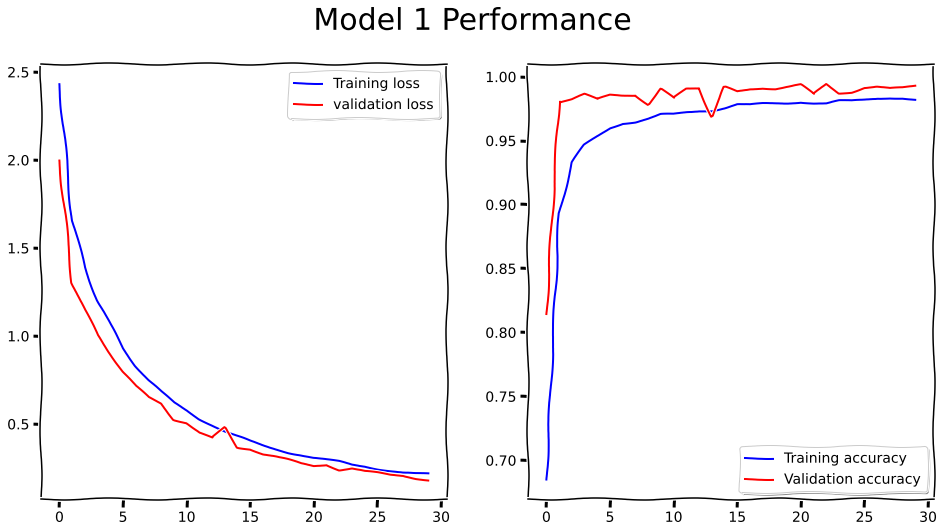

In [32]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.plot(history1.history['loss'], color='b', label="Training loss")
plt.plot(history1.history['val_loss'], color='r', label="validation loss",)
plt.legend(loc='best', shadow=True)
plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend(loc='best', shadow=True)
plt.suptitle("Model 1 Performance",fontsize = 30)
plt.show()

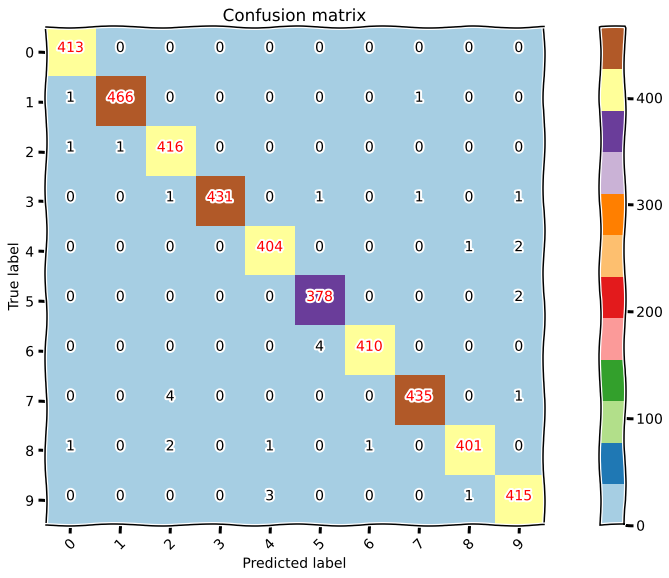

In [40]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Paired):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model1.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

In [15]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model2 = Sequential()

model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))


model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.25))


model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation = "softmax"))

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
ckpt = ModelCheckpoint('cnn_model.h5',
                            verbose=1, save_weights_only=True,save_best_only = True)
epochs = 30 
batch_size = 86

model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
history2 = model2.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 30, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,ckpt])

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.1276 - accuracy: 0.6157
Epoch 00001: val_loss improved from inf to 0.17344, saving model to cnn_model.h5
439/439 [==============================] - 137s 312ms/step - loss: 1.1276 - accuracy: 0.6157 - val_loss: 0.1734 - val_accuracy: 0.9526 - lr: 1.0000e-04
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8871
Epoch 00002: val_loss improved from 0.17344 to 0.09904, saving model to cnn_model.h5
439/439 [==============================] - 137s 313ms/step - loss: 0.3670 - accuracy: 0.8871 - val_loss: 0.0990 - val_accuracy: 0.9710 - lr: 1.0000e-04
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.9221
Epoch 00003: val_loss improved from 0.09904 to 0.07740, saving model to cnn_model.h5
439/439 [==============================] - 137s 312ms/step - loss: 0.2585 - accuracy: 0.9221 - val_loss: 0.0774 - val_accuracy: 0.9783 - lr: 1.0000e-04
Epoch

439/439 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9831
Epoch 00026: val_loss did not improve from 0.02800
439/439 [==============================] - 137s 312ms/step - loss: 0.0543 - accuracy: 0.9831 - val_loss: 0.0318 - val_accuracy: 0.9924 - lr: 1.0000e-04
Epoch 27/30
439/439 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9827
Epoch 00027: val_loss did not improve from 0.02800
439/439 [==============================] - 142s 323ms/step - loss: 0.0551 - accuracy: 0.9827 - val_loss: 0.0287 - val_accuracy: 0.9910 - lr: 1.0000e-04
Epoch 28/30
439/439 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9842
Epoch 00028: val_loss did not improve from 0.02800
439/439 [==============================] - 139s 316ms/step - loss: 0.0519 - accuracy: 0.9842 - val_loss: 0.0316 - val_accuracy: 0.9921 - lr: 1.0000e-04
Epoch 29/30
439/439 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9857
Epoch 00029: va

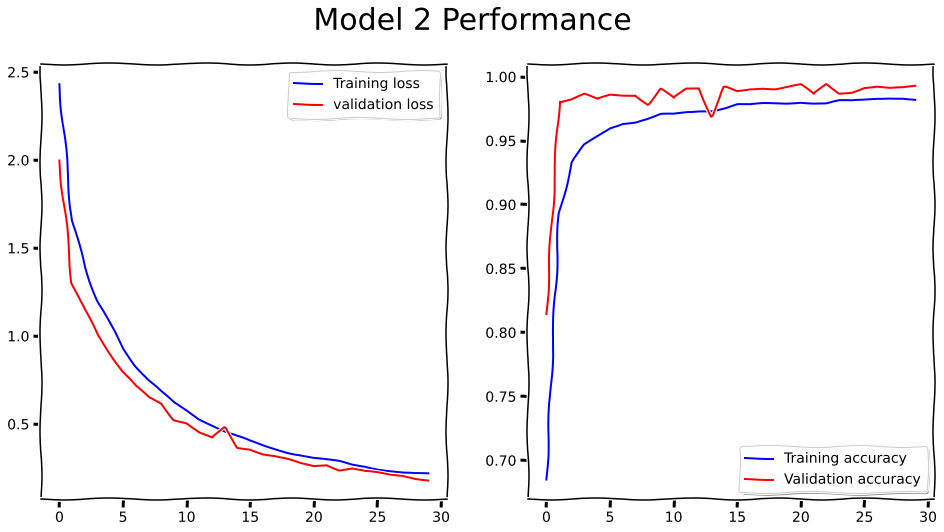

In [33]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.plot(history1.history['loss'], color='b', label="Training loss")
plt.plot(history1.history['val_loss'], color='r', label="validation loss",)
plt.legend(loc='best', shadow=True)
plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend(loc='best', shadow=True)
plt.suptitle("Model 2 Performance",fontsize = 30)
plt.show()

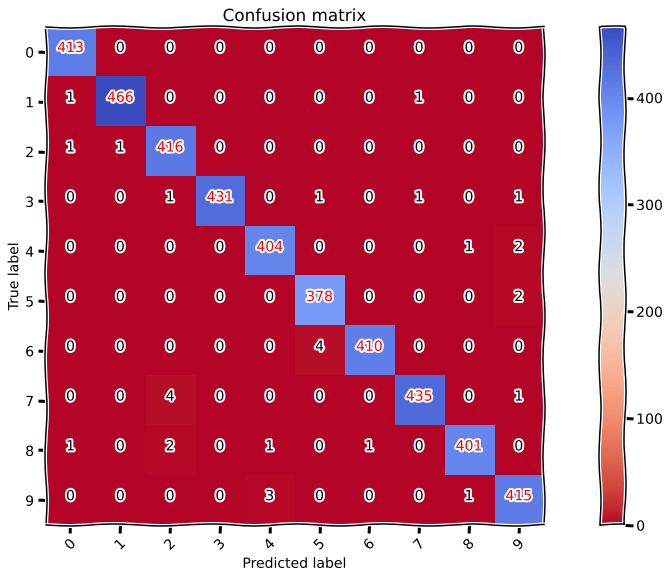

In [41]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.coolwarm_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model1.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

1. The model2 reaches almost 99.30% accuracy on validation dataset after 30 epochs, could train for more epochs with decrease in learning rate. 

2. Train and validation accuracy is almost close so there is no overfitting definitely.

In [45]:
sub = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
def predict_test(data,model):
    data = data / 255.0
    data = data.values.reshape(-1,28,28,1)
    return(model.predict(data))

res = predict_test(test,model1)

In [55]:
final_result = []
for i in range(len(res)):
    final_result.append(np.argmax(res[i]))
sub['Label'] = final_result

## Performance Comparison & Erros For Each Model

In [45]:
# skip connection network
model1.load_weights("../input/digit-recognizer-model/res_model.h5")

# cnn model
model2.load_weights("../input/digit-recognizer-model/cnn_model.h5")

def display(mode1,model2,data):
    # (batch_size,img_dim,img_dim,filters)
    # model 1 prediction
    p1 = np.argmax(model1.predict(data.values.reshape(-1,28,28,1)),axis=1)
    # model 2 prediction
    p2 = model2.predict_classes(data.values.reshape(-1,28,28,1))
    plt.figure(figsize = (24,10))
    for i in range(8):
        plt.subplot(2,4,i+1)
        r = np.random.choice(20000)
        plt.title(f"Model1 Predicted {p1[r]}\nModel2 Predicted {p2[r]}")
        plt.imshow(data.iloc[r].values.reshape(28,28),cmap = 'gray')
        plt.grid(False)
        plt.axis(False)
    plt.show()
        
    

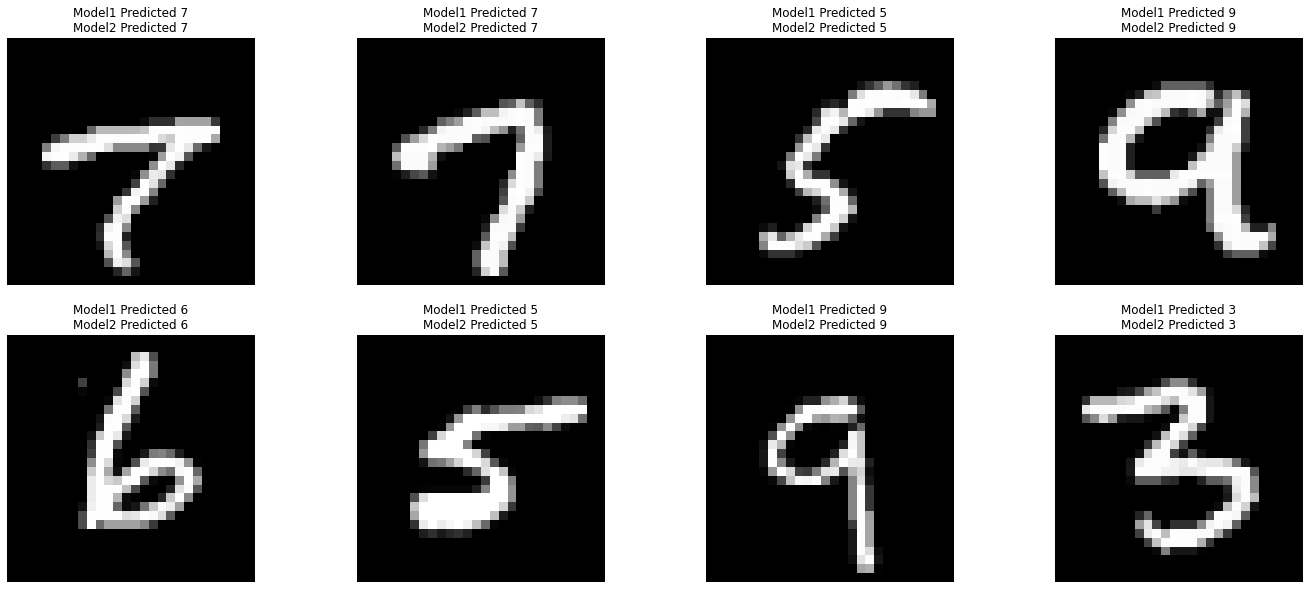

In [46]:
display(model1,model2,test)

### Let's investigate for errors.(Curious!!! Then let's dive in)

#### I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

In [73]:
def error(model,data):
    try:
        # this is for funtional model
        p1 = np.argmax(model.predict(data.drop(['label'],axis=1).values.reshape(-1,28,28,1)),axis=1)
    except:
        # this is for sequential model
        p1 = model.predict_classes(data.drop(['label'],axis=1).values.reshape(-1,28,28,1))
    
    df = data[p1-data['label'].values!=0]
    plt.figure(figsize = (24,10))
    i=0
    for indx in np.random.choice(df.index.tolist(),8):       
        plt.subplot(2,4,i+1)
        #r = np.random.choice(20000)
        plt.title(f"Actual Label {data.iloc[indx]['label']}\nModel1 Predicted {p1[indx]}")
        plt.imshow(train.drop(['label'],axis=1).iloc[indx].values.reshape(28,28),cmap = 'gray')
        plt.grid(False)
        plt.axis(False)
        i+=1
    plt.show()

### Model1 Error

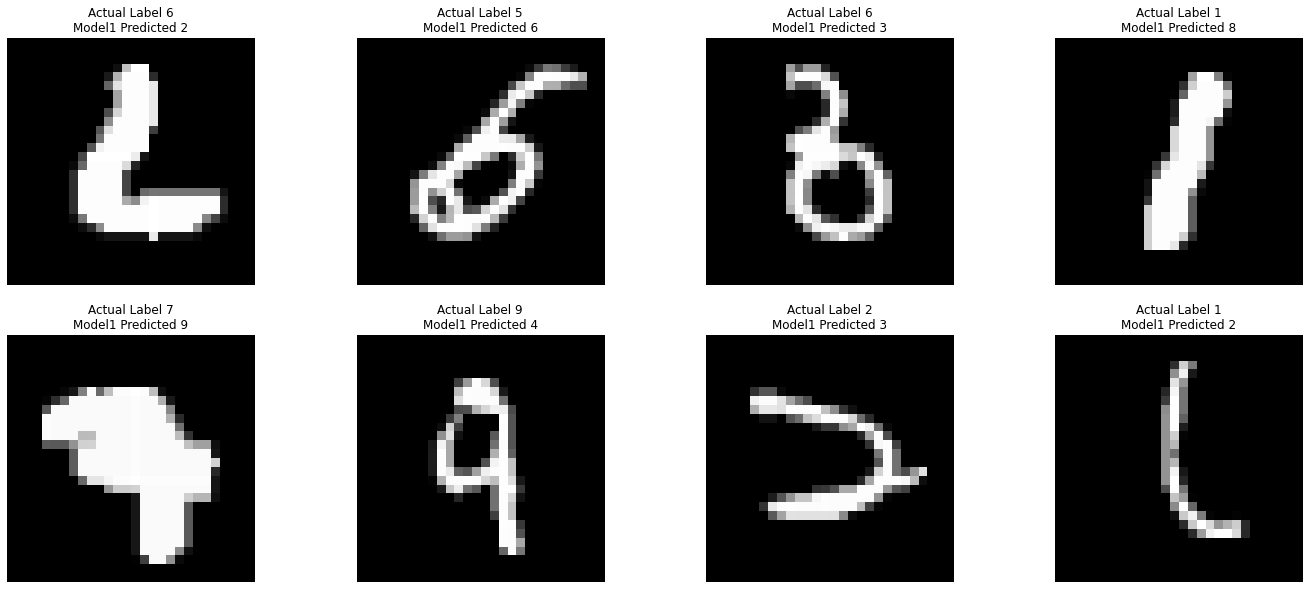

In [74]:
error(model1,train)

### Model2 Error

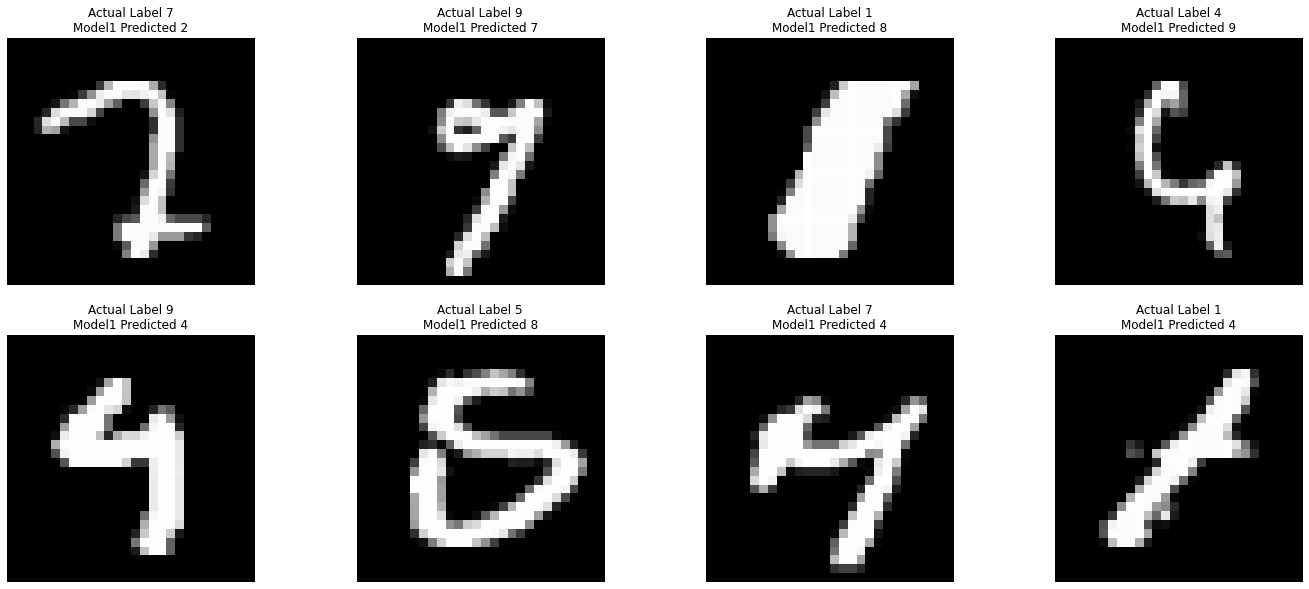

In [75]:
error(model2,train)

#### If you had a great time reading this notebook, do some upvotes and comments too wherever you think there is need of some improvement.

#### If you have more intuitive ideas to improve the accuracy pls do comment, it will be much appreciated...